# Churn Prediction Notebook

Predict customer churn

# Import Libraries

In [101]:
# Import necessary libraries
import shap
import joblib
import pandas as pd
import numpy as np
import churn_library as cls
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

# Data Obtainance, Cleaning and Exploration

## Data Obtainance and Exploration

In [102]:
# Import data
df = cls.import_data(r"./data/bank_data.csv")

df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [103]:
# View the shape of the data
df.shape

(10127, 22)

In [104]:
# Look for null values
df.isnull().sum()

Unnamed: 0                  0
CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [105]:
# Look at a statistical analysis of the data
df.describe()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,5063.000000,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,2923.557422,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,2531.500000,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,5063.000000,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7594.500000,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,10126.000000,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


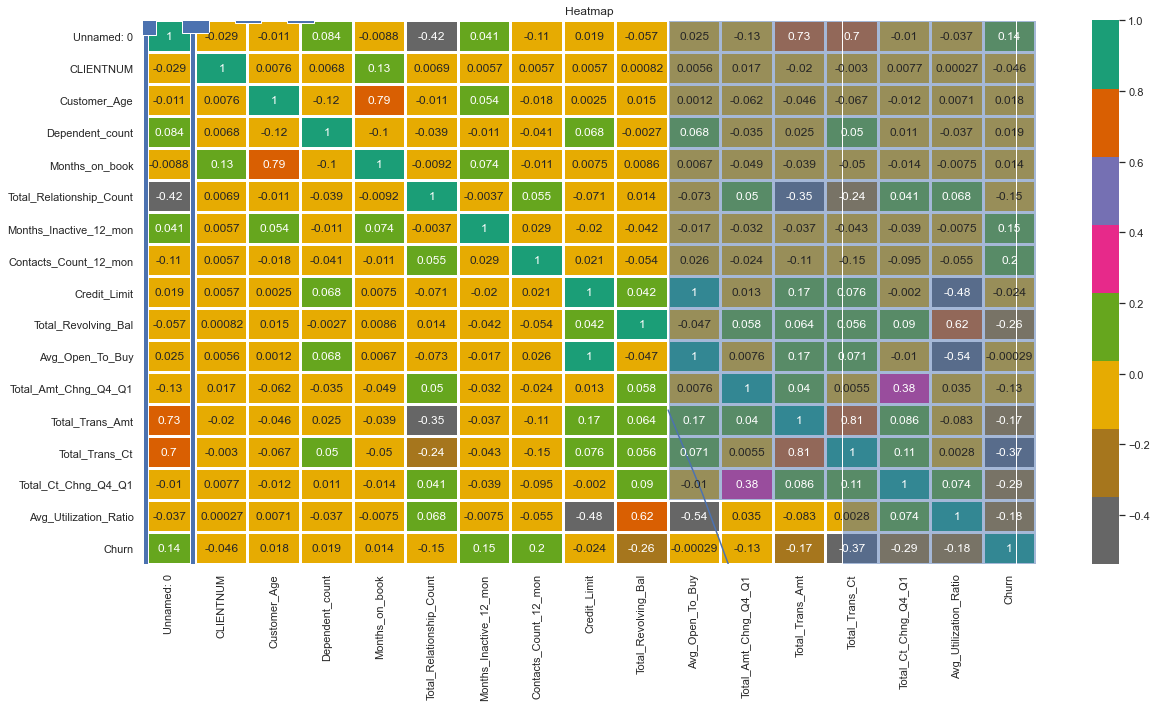

In [106]:
# Save data explorations
cls.perform_eda(df)

## Data Cleaning and Feature Engineering

In [107]:
# Columns present
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

In [108]:
# Create churn column
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

In [109]:
# Encode data
encoded_df = cls.encoder_helper(df, cat_columns, 'Churn')

In [110]:
# Choose columns and split the data
x_train, x_test, y_train, y_test = cls.perform_feature_engineering(encoded_df, 'Churn')

# Modelling

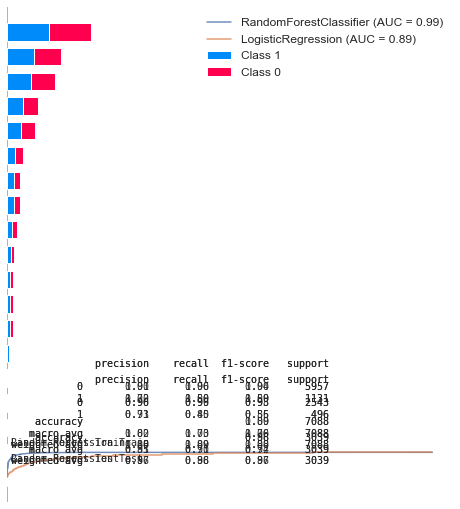

In [111]:
# Train model and save results
cls.train_models(x_train, x_test, y_train, y_test)
